## FontStyleGAN


### Setup

In [31]:
%load_ext autoreload
%autoreload 2

# matplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Core libraries
import numpy as np
import torch

# The folliwing line is useful in Jupyter notebook
%matplotlib inline

USE_GPU = True

data_type = torch.FloatTensor

if USE_GPU and torch.cuda.is_available():
    data_type = torch.cuda.FloatTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([1, 64, 1664])


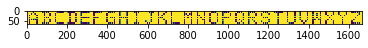

In [2]:
from data.font_dataset import FontDataset
from data.font_data_loader import FontDataLoader

dataset = FontDataset('./datasets/fonts/')

import torchvision.transforms as transforms

print(dataset[0].shape)

# Show what a normalized image looks like.
plt.imshow(transforms.Compose([
    transforms.ToPILImage()
])(dataset[0]))

torch.Size([64, 64])


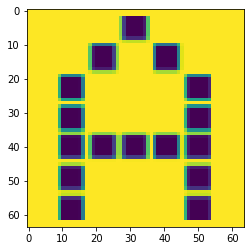

In [3]:
single_image = dataset[0][0,:,0:64]
print(single_image.shape)

# Sample a specific image
plt.imshow(transforms.Compose([
    transforms.ToPILImage()
])(single_image))

In [50]:
from models.models import build_font_shape_generator, build_font_shape_discriminator
from torchviz import make_dot

G = build_font_shape_generator()
D = build_font_shape_discriminator()

if USE_GPU and torch.cuda.is_available():
    G.cuda()
    D.cuda()

data_loader = FontDataLoader(dataset, batch_size=5)
for data in data_loader:
    # For now, only use A
    generated = G(data[:,:,:,0:64].type(data_type))
    
    # Flatten the generated shape
    generated_shape = generated.shape
    generated = generated.reshape(generated_shape[0], generated_shape[1], 64, 2048)
    print(generated.shape)
    
    # Extract only letters A-Z (ignore blank space) (64 x 26 = 1664)
    generated = generated[:, :, :, 0:1664]
    
    print(D(generated))
    break

# make_dot(G(x), params=dict(model.named_parameters()))
# dot

torch.Size([5, 1, 64, 2048])


IndexError: index 5 is out of bounds for dimension 0 with size 5

In [24]:
a = np.arange(6).reshape((3, 2))
a = a.reshape(np.newaxis, 1)
a

TypeError: 'NoneType' object cannot be interpreted as an integer